# American Sign Language (ASL) Alphabet Classification using CNN

# Problem Statement

### What problem are you solving?
I am building a multi-class image classification model to recognize American Sign Language (ASL) fingerspelling gestures. The goal is to correctly classify images of hand signs into one of 28 possible classes: the 26 English alphabet letters (A-Z) plus the signs for "space" and "nothing".

I am using the ASL Alphabet dataset from Kaggle, which contains over 223,000 RGB images of hand gestures captured in controlled lighting environments. Each class is represented by thousands of labeled images at a resolution of 200x200 pixels.

### Why is this problem important?
Effective ASL recognition has the potential to enhance communication accessibility for the Deaf and Hard of Hearing community. Real-time gesture recognition systems could power tools such as:

- ASL-to-text translators for communication in public spaces.

- Assistive technologies for education or customer service scenarios.

- Gesture interfaces in AR/VR environments or robotics.

By focusing on fingerspelling, which represents the spelling of individual letters, this project tackles a foundational building block for broader ASL translation and can be integrated into larger sign language recognition systems.

### Why use Deep Learning?
Hand gestures can vary greatly in terms of lighting, orientation, skin tone, hand shape, and background clutter.

Convolutional Neural Networks (CNNs) are well-suited to this task because they:

- Automatically learn spatial hierarchies of features directly from raw pixels.

- Are robust to translations and distortions common in gesture images.

- Can scale to large, labeled datasets like the one used here.

Given the complexity of the visual patterns in ASL hand signs, deep learning—specifically CNNs is a good solution.

---

In [ ]:
# IMPORTS AND CONSTANTS
import os
import sys
import zipfile
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from keras_tuner.engine.hyperparameters import HyperParameters
from PIL import Image
from keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

GLOBAL_SEED = 420
NUM_CLASSES = 28
random.seed(12345)

# Add root directory (one level up from notebooks/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

2025-06-02 18:48:41.450773: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 18:48:41.472243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-02 18:48:41.472281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-02 18:48:41.472299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 18:48:41.477867: I tensorflow/core/platform/cpu_feature_g

---

# Problem Setup

### Data

The dataset comes from [Kaggle](https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset). It consists of 223k photos of ASL letters, and signs for "space", "delete", and "nothing".


In [2]:
# Download dataset and unzip it
if not os.path.isdir(r"./ASL_Alphabet_Dataset"):
    if not os.path.isfile(r"./asl-dataset.zip"): # Only download if zip isn't present
        !curl -L -o ./asl-dataset.zip \
            https://www.kaggle.com/api/v1/datasets/download/debashishsau/aslamerican-sign-language-aplhabet-dataset

    zip_path = r"./asl-dataset.zip"
    extract_to = r"./"

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    os.remove(zip_path)
else:
    print("Dataset already exists")

Dataset already exists


In [3]:
# Remove "delete" folder
if os.path.isdir(r"./ASL_Alphabet_Dataset/asl_alphabet_train/del"):
    shutil.rmtree(r"./ASL_Alphabet_Dataset/asl_alphabet_train/del")
else:
    print("Directory already removed")

Directory already removed


### Inputs and Outputs
- Input: 200x200 RGB .jpg images
- Output: Target labels of A-Z characters, space, and nothing

### Variable Summary Table

| Variable        | Type         | Range                | Encoding               |
|-----------------|--------------|----------------------|------------------------|
| Image           | Tensor       | (200, 200, 3)        | Normalized RGB pixels  |
| Label           | Categorical  | A-Z, space, nothing  | One-hot / Integer      |


In [4]:
# Load training and validation sets
train_ds, val_ds = image_dataset_from_directory(
    r"./ASL_Alphabet_Dataset/asl_alphabet_train",
    image_size=(200, 200),
    batch_size=32,
    validation_split=0.2,
    subset="both",
    seed=GLOBAL_SEED
)

Found 216238 files belonging to 28 classes.
Using 172991 files for training.
Using 43247 files for validation.


2025-06-02 18:50:23.897786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-02 18:50:23.915502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-02 18:50:23.915529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-02 18:50:23.918284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-02 18:50:23.918312: I tensorflow/compile

In [5]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


In [6]:
for images, labels in train_ds.take(1):
    print("Single image shape:", images[0].shape) # (height, width, channels)
    break

Single image shape: (200, 200, 3)



---

# Problem Exploration

### Exploratory Data Analysis
- Visualize sample images from different classes
- Analyze class distribution


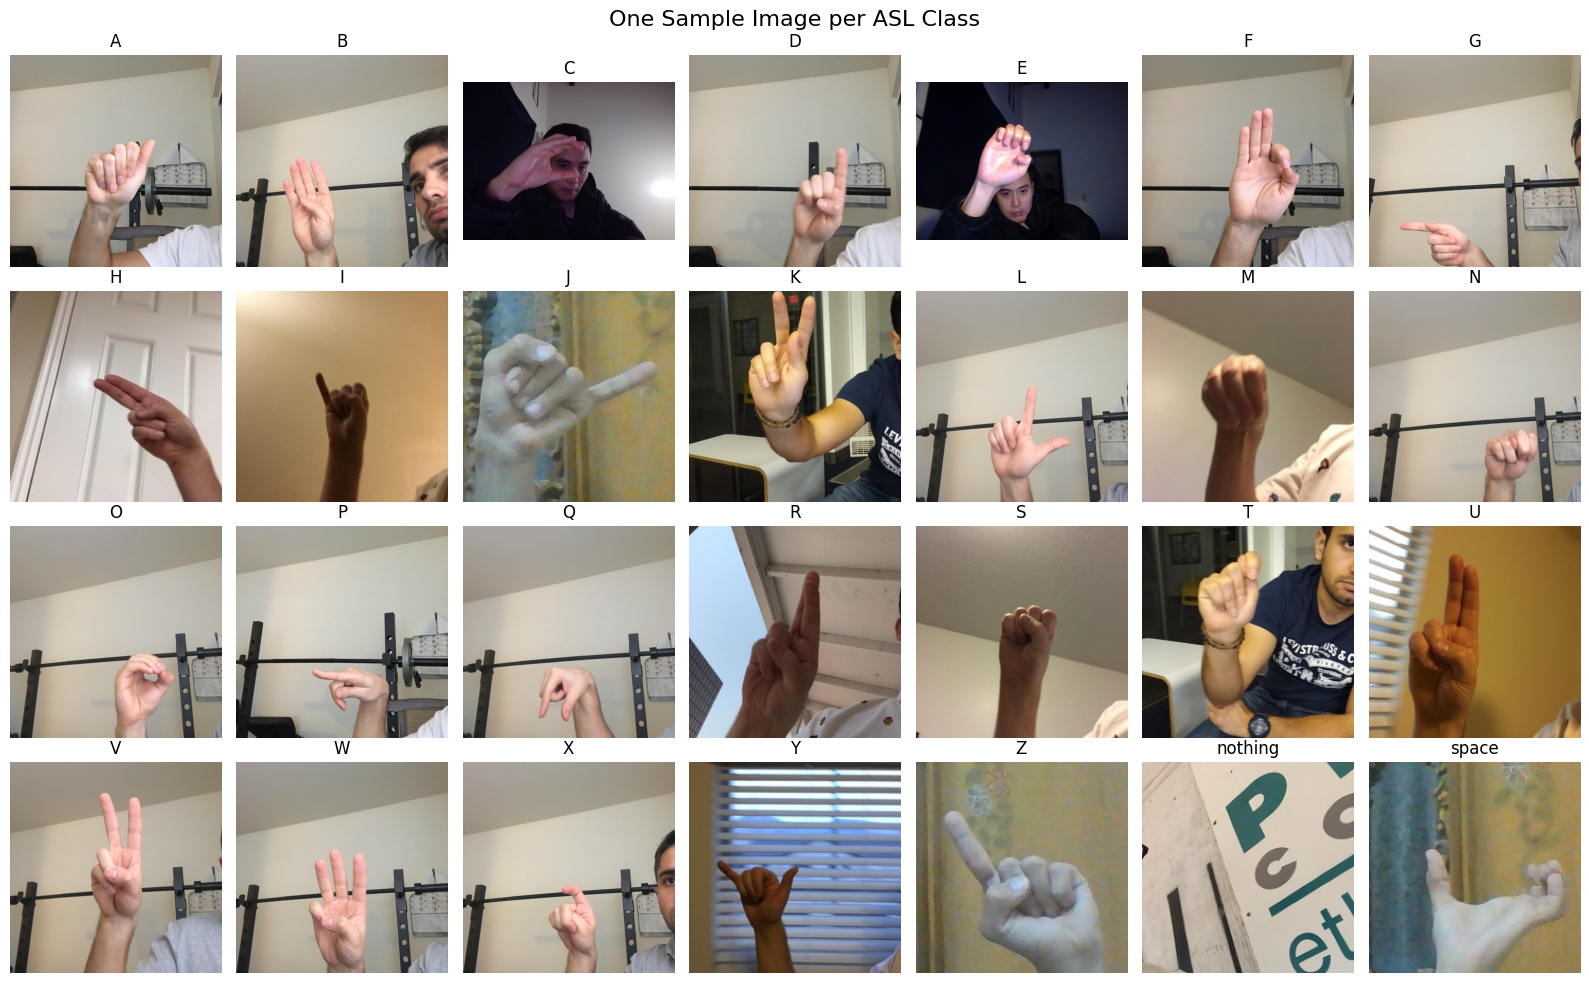

In [7]:
base_path = './ASL_Alphabet_Dataset/asl_alphabet_train'

plt.figure(figsize=(16, 10))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(base_path, class_name)
    image_path = os.path.join(class_dir, os.listdir(class_dir)[0])  # First image in class folder
    img = Image.open(image_path)

    ax = plt.subplot(4, 7, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.suptitle("One Sample Image per ASL Class", fontsize=16)
plt.tight_layout()
plt.show()

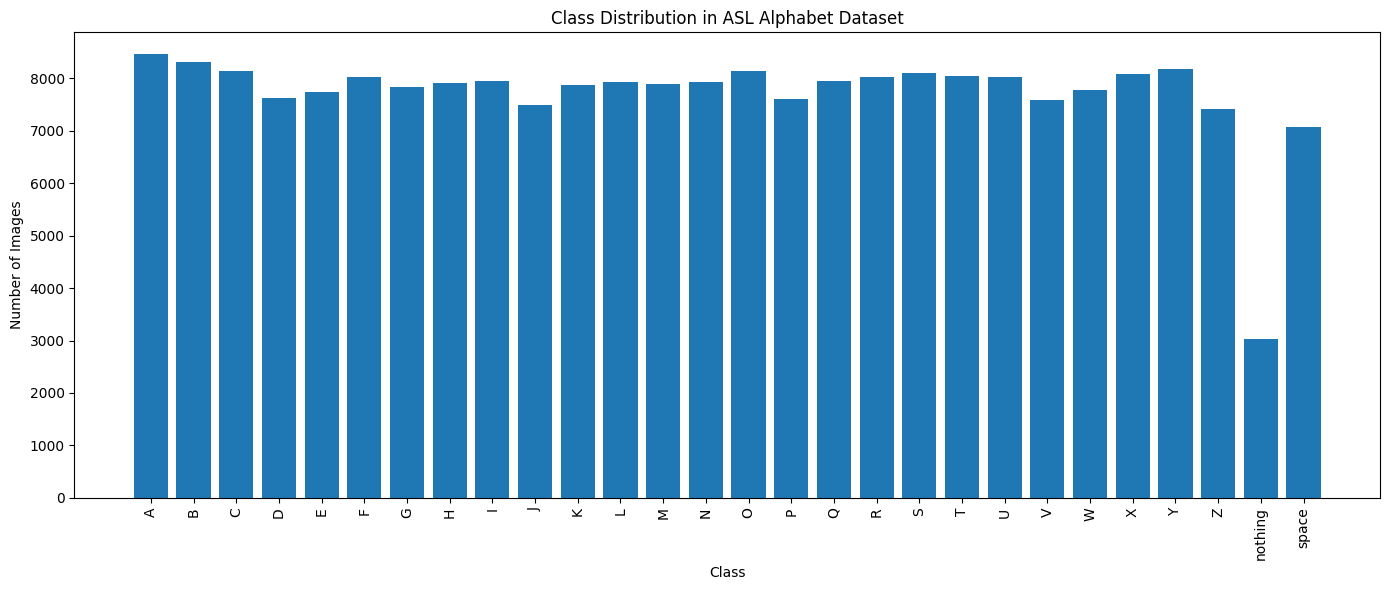

In [8]:
class_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in class_names}

plt.figure(figsize=(14, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class Distribution in ASL Alphabet Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


### Bias and Data Quality
- Are there any visible biases in data?
    - There is significantly less "nothing" images than all of the other classes. This can lead to some issues since there is less images to show distinction between when there is ASL alphabet characters in the image vs nothing.

- Discuss how the data is cleaned/preprocessed and why
    - Removed the "del" folder which was not a relevant class.

    - Applied normalization to rescale pixel values from [0, 255] to [0, 1].

    - Used prefetch and shuffle to optimize training pipeline and improve training variability.

    - All images are resized to 200×200 to ensure consistent input shape.

    - Data pipeline includes shuffling to prevent ordering bias and prefetch for efficiency.


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
autotune = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) \
                   .shuffle(1000) \
                   .prefetch(buffer_size=autotune)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) \
               .prefetch(buffer_size=autotune)



### Baseline Model
- Chose a simple shallow CNN with two convolutional layers as our baseline, since classical ML methods are poorly suited for raw image inputs and do not scale well to high-dimensional pixel data.


In [10]:
baseline_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


2025-06-02 18:50:39.337238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 584 of 1000
2025-06-02 18:50:46.067011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-06-02 18:50:46.133883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-06-02 18:50:46.702455: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef2746abcc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-02 18:50:46.702507: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-06-02 18:50:46.707305: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-02 18:50:46.758911: I ./tensorflow/compiler/jit/device_comp

5406/5406 [==============================] - 126s 20ms/step - loss: 0.8344 - accuracy: 0.7528 - val_loss: 0.3102 - val_accuracy: 0.9049
Epoch 2/10


2025-06-02 18:52:45.312312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 646 of 1000


   5/5406 [..............................] - ETA: 2:56 - loss: 0.3041 - accuracy: 0.9062  

2025-06-02 18:52:50.738281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 122s 20ms/step - loss: 0.1953 - accuracy: 0.9416 - val_loss: 0.1842 - val_accuracy: 0.9512
Epoch 3/10


2025-06-02 18:54:47.526291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 646 of 1000


   5/5406 [..............................] - ETA: 2:46 - loss: 0.0809 - accuracy: 0.9688  

2025-06-02 18:54:52.999301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 122s 20ms/step - loss: 0.1098 - accuracy: 0.9664 - val_loss: 0.1602 - val_accuracy: 0.9600
Epoch 4/10


2025-06-02 18:56:49.140960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 645 of 1000


   5/5406 [..............................] - ETA: 2:51 - loss: 0.0364 - accuracy: 1.0000  

2025-06-02 18:56:54.527511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 122s 20ms/step - loss: 0.0759 - accuracy: 0.9770 - val_loss: 0.1822 - val_accuracy: 0.9609
Epoch 5/10


2025-06-02 18:58:51.239989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 645 of 1000


   5/5406 [..............................] - ETA: 2:44 - loss: 0.0784 - accuracy: 0.9812  

2025-06-02 18:58:56.626545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 121s 20ms/step - loss: 0.0575 - accuracy: 0.9829 - val_loss: 0.1563 - val_accuracy: 0.9707
Epoch 6/10


2025-06-02 19:00:52.439881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 643 of 1000


   5/5406 [..............................] - ETA: 2:59 - loss: 0.0162 - accuracy: 0.9937  

2025-06-02 19:00:57.827618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 122s 20ms/step - loss: 0.0488 - accuracy: 0.9863 - val_loss: 0.1843 - val_accuracy: 0.9632
Epoch 7/10


2025-06-02 19:02:54.397583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 645 of 1000


  11/5406 [..............................] - ETA: 1:32 - loss: 0.0711 - accuracy: 0.9886

2025-06-02 19:02:59.851138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 124s 20ms/step - loss: 0.0398 - accuracy: 0.9881 - val_loss: 0.1817 - val_accuracy: 0.9681
Epoch 8/10


2025-06-02 19:04:58.461126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 654 of 1000


   5/5406 [..............................] - ETA: 2:47 - loss: 0.0163 - accuracy: 1.0000  

2025-06-02 19:05:03.900411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 122s 20ms/step - loss: 0.0367 - accuracy: 0.9900 - val_loss: 0.1543 - val_accuracy: 0.9747
Epoch 9/10


2025-06-02 19:07:00.338096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 653 of 1000


   5/5406 [..............................] - ETA: 2:53 - loss: 0.0405 - accuracy: 0.9875      

2025-06-02 19:07:05.742342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 122s 20ms/step - loss: 0.0334 - accuracy: 0.9909 - val_loss: 0.1885 - val_accuracy: 0.9704
Epoch 10/10


2025-06-02 19:09:02.818708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 641 of 1000


   5/5406 [..............................] - ETA: 2:55 - loss: 0.0385 - accuracy: 0.9875  

2025-06-02 19:09:08.256088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 122s 20ms/step - loss: 0.0300 - accuracy: 0.9920 - val_loss: 0.1669 - val_accuracy: 0.9757


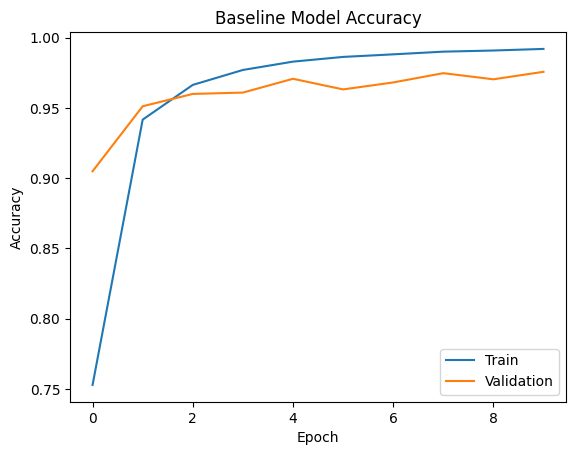

In [12]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


---

# Neural Network Implementation

### CNN Architecture
Design Justification:

- 3 convolutional layers: progressively extract low-to-high level features (edges → patterns → shapes).

- Increased filter depth: from 32 → 128 channels to allow more expressive feature learning.

- Activation: ReLU used for its computational efficiency, ability to prevent vanishing gradients, and tendency to produce sparse, generalizable activations—making it ideal for deep CNNs.

- MaxPooling layers: reduce spatial size while retaining key patterns.

- Dropout: added before final classification to prevent overfitting.

- Softmax output: ensures probabilistic class predictions for 28 output classes.

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


### Training Procedure
- Training/validation accuracy and loss curves
- Use of regularization (dropout, batch norm)
- Optimizer and learning rate


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("initial_model.h5", save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=10
)

Epoch 1/10


2025-06-02 19:11:05.153310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 629 of 1000
2025-06-02 19:11:10.803738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - ETA: 0s - loss: 1.1757 - accuracy: 0.6264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5406/5406 [==============================] - 142s 23ms/step - loss: 1.1757 - accuracy: 0.6264 - val_loss: 0.2384 - val_accuracy: 0.9367
Epoch 2/10


2025-06-02 19:13:26.624779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 649 of 1000


   2/5406 [..............................] - ETA: 6:36 - loss: 0.6618 - accuracy: 0.7969    

2025-06-02 19:13:31.997829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 136s 22ms/step - loss: 0.4121 - accuracy: 0.8635 - val_loss: 0.1192 - val_accuracy: 0.9685
Epoch 3/10


2025-06-02 19:15:43.094034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 644 of 1000


   2/5406 [..............................] - ETA: 6:33 - loss: 0.2807 - accuracy: 0.9219    

2025-06-02 19:15:48.554547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 136s 22ms/step - loss: 0.2753 - accuracy: 0.9098 - val_loss: 0.0779 - val_accuracy: 0.9785
Epoch 4/10


2025-06-02 19:17:59.057641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 653 of 1000


   2/5406 [..............................] - ETA: 6:27 - loss: 0.1203 - accuracy: 0.9688    

2025-06-02 19:18:04.562383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 136s 22ms/step - loss: 0.2157 - accuracy: 0.9291 - val_loss: 0.0742 - val_accuracy: 0.9795
Epoch 5/10


2025-06-02 19:20:15.027843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 646 of 1000


   2/5406 [..............................] - ETA: 6:03 - loss: 0.1476 - accuracy: 0.9375    

2025-06-02 19:20:20.405980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 136s 22ms/step - loss: 0.1792 - accuracy: 0.9416 - val_loss: 0.0683 - val_accuracy: 0.9808
Epoch 6/10


2025-06-02 19:22:30.672070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 652 of 1000


   3/5406 [..............................] - ETA: 5:37 - loss: 0.2063 - accuracy: 0.9375  

2025-06-02 19:22:36.002972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 136s 22ms/step - loss: 0.1554 - accuracy: 0.9491 - val_loss: 0.0584 - val_accuracy: 0.9840
Epoch 7/10


2025-06-02 19:24:46.610692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 644 of 1000


   2/5406 [..............................] - ETA: 5:56 - loss: 0.1733 - accuracy: 0.9219    

2025-06-02 19:24:51.941318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 135s 22ms/step - loss: 0.1372 - accuracy: 0.9552 - val_loss: 0.0484 - val_accuracy: 0.9875
Epoch 8/10


2025-06-02 19:27:01.887319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 637 of 1000


   3/5406 [..............................] - ETA: 5:42 - loss: 0.1406 - accuracy: 0.9271  

2025-06-02 19:27:07.536722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 135s 22ms/step - loss: 0.1263 - accuracy: 0.9591 - val_loss: 0.0512 - val_accuracy: 0.9877
Epoch 9/10


2025-06-02 19:29:16.941351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 642 of 1000


   2/5406 [..............................] - ETA: 6:10 - loss: 0.0519 - accuracy: 0.9688    

2025-06-02 19:29:22.309685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 135s 22ms/step - loss: 0.1141 - accuracy: 0.9631 - val_loss: 0.0453 - val_accuracy: 0.9888
Epoch 10/10


2025-06-02 19:31:32.180872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 648 of 1000


   2/5406 [..............................] - ETA: 6:14 - loss: 0.2597 - accuracy: 0.9688    

2025-06-02 19:31:37.586704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 135s 22ms/step - loss: 0.1073 - accuracy: 0.9660 - val_loss: 0.0598 - val_accuracy: 0.9852



### Evaluation
- Final performance metrics on validation/test set
- Include a confusion matrix if applicable


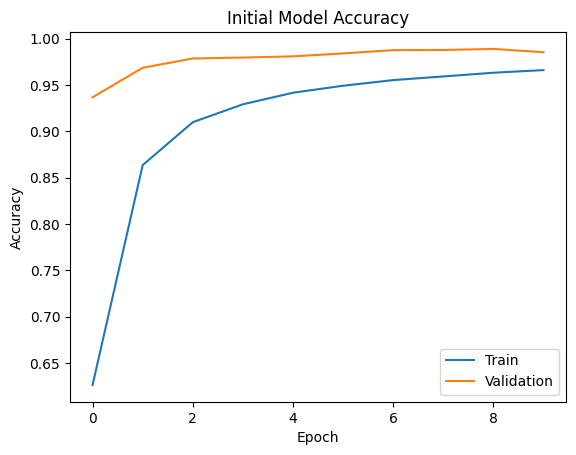

In [15]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Initial Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1352/1352 [==============================] - 22s 16ms/step - loss: 0.0598 - accuracy: 0.9852
Validation Loss: 0.0598
Validation Accuracy: 0.9852


1/1 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

           A       0.97      0.99      0.98      1654
           B       0.98      0.99      0.99      1678
           C       0.98      1.00      0.99      1661
           D       0.97      0.99      0.98      1566
           E       0.99      0.98      0.99      1541
           F       1.00      0.99      0.99      1607
           G       0.99      0.99      0.99      1583
           H       0.98      0.98      0.98      1528
           I       0.99      0.98      0.99      1593
           J       0.99      0.99      0.99      1541
           K       0.99      0.99      0.99      1558
           L       1.00      0.99      0.99      1654
           M       0.98      0.97      0.98      1585
           N       0.98      0.98      0.98      1641
           O       0.99      0.99      0.99      1598
           P       0.99      1.00      0.99      1505
           Q       0.99      

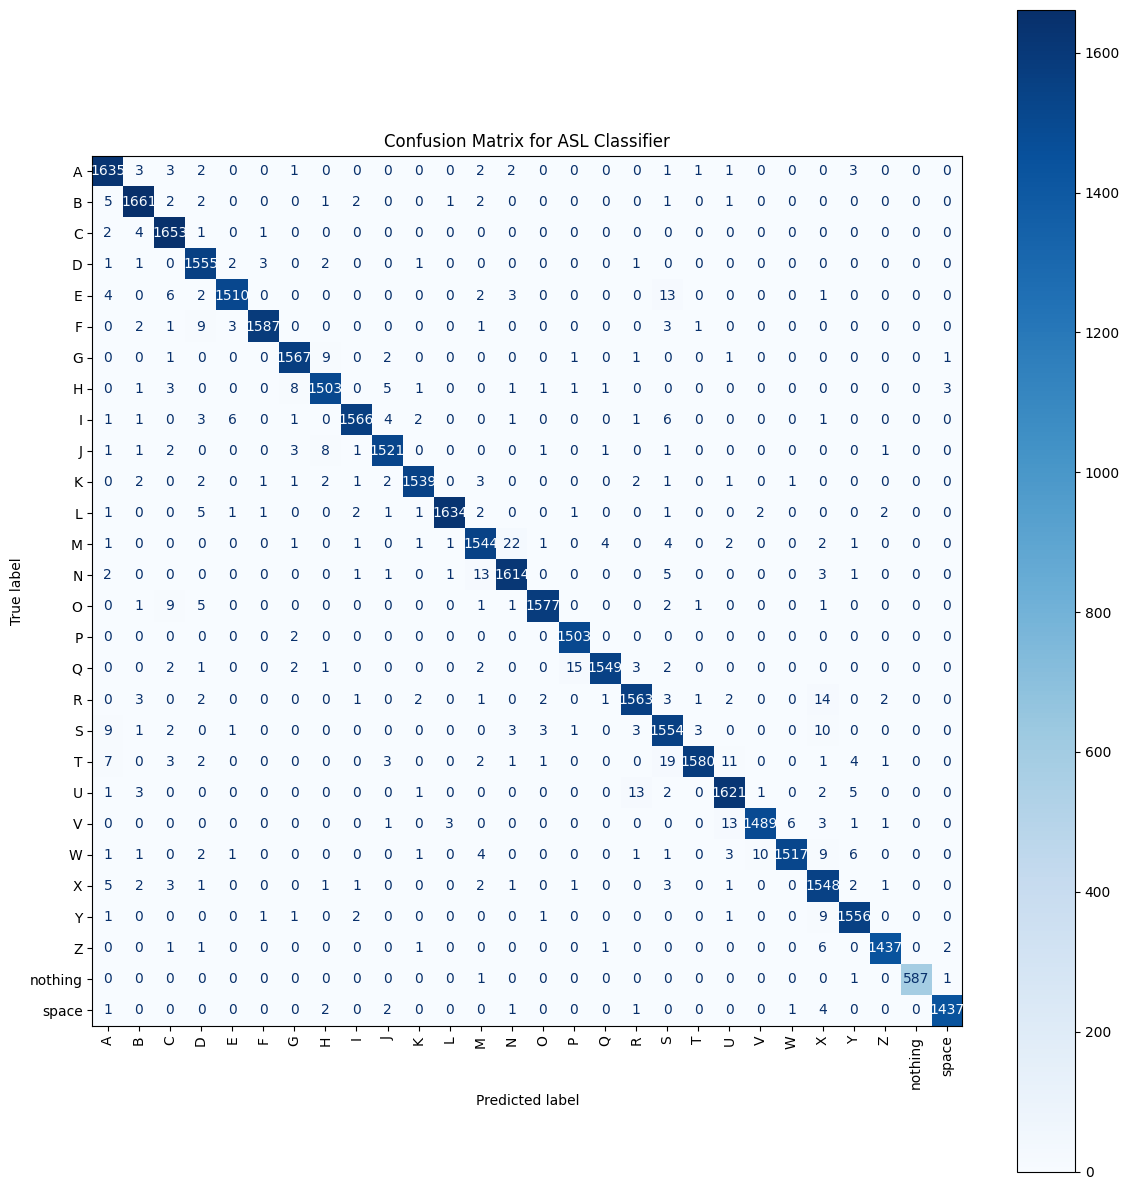

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix for ASL Classifier")
plt.tight_layout()
plt.show()


---

# Model Refinement


In [ ]:
# Model builder function
def build_model(hp):
    model = models.Sequential()

    filters1 = hp.get('filters1')
    filters2 = hp.get('filters2')
    dense_units = hp.get('dense_units')
    dropout_rate = hp.get('dropout')
    num_blocks = hp.get('num_conv_blocks')

    # First conv block
    model.add(layers.Conv2D(filters1, (3, 3), activation='relu', input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D(2, 2))

    # Second conv block
    model.add(layers.Conv2D(filters2, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))

    # Third conv block
    if num_blocks == 3:
        model.add(layers.Conv2D(filters2 * 2, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# History tracker callback
class HistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

# Manual random search runner
def run_manual_random_search(train_ds, val_ds):
    MAX_TRIALS = 10
    history_per_trial = []
    for trial in range(MAX_TRIALS):
        # Random hyperparameter sampling
        filters1_val = random.choice([32, 64])
        filters2_val = random.choice([64, 128])
        dense_units_val = random.choice([128, 256])
        dropout_val = random.choice([0.2, 0.3, 0.5])
        num_conv_blocks = random.choice([2, 3])

        # Lock into HyperParameters
        hp = HyperParameters()
        hp.Fixed('filters1', filters1_val)
        hp.Fixed('filters2', filters2_val)
        hp.Fixed('dense_units', dense_units_val)
        hp.Fixed('dropout', dropout_val)
        hp.Fixed('num_conv_blocks', num_conv_blocks)

        try:
            model = build_model(hp)
            history_callback = HistoryCallback()
            trial_model_path = f"best_model_trial_{trial}.h5"

            callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=2),
                tf.keras.callbacks.ModelCheckpoint(trial_model_path, save_best_only=True),
                history_callback
            ]

            print(f"\nTrial {trial + 1}/{MAX_TRIALS} hyperparameters: {hp.values}\n")
            model.fit(train_ds, 
                      validation_data=val_ds, 
                      epochs=10, 
                      callbacks=callbacks, 
                      verbose=1)

            val_acc = history_callback.history['val_accuracy'][-1]
            history_per_trial.append({
                'trial_id': trial,
                'hp': hp.values,
                'val_accuracy': val_acc,
                'history': history_callback.history,
                'model_path': trial_model_path
            })

        except tf.errors.ResourceExhaustedError:
            history_per_trial.append({
                'trial_id': None,
                'hp': None,
                'val_accuracy': None,
                'history': None,
                'model_path': None
            })
            print(f"Skipping trial {trial + 1} due to GPU OOM.")

    return history_per_trial


# Run the random search
trial_history = run_manual_random_search(train_ds, val_ds)


Trial 1/10 hyperparameters: {'filters1': 64, 'filters2': 64, 'dense_units': 128, 'dropout': 0.2, 'num_conv_blocks': 3}

Epoch 1/10


2025-06-02 20:53:33.672766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 627 of 1000
2025-06-02 20:53:39.381888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - ETA: 0s - loss: 0.9410 - accuracy: 0.7055

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5406/5406 [==============================] - 193s 33ms/step - loss: 0.9410 - accuracy: 0.7055 - val_loss: 0.2115 - val_accuracy: 0.9390
Epoch 2/10


2025-06-02 20:56:45.993466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 620 of 1000


   5/5406 [..............................] - ETA: 2:45 - loss: 0.3887 - accuracy: 0.8750  

2025-06-02 20:56:52.576811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.2579 - accuracy: 0.9167 - val_loss: 0.0962 - val_accuracy: 0.9726
Epoch 3/10


2025-06-02 20:59:57.413950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 620 of 1000


   2/5406 [..............................] - ETA: 7:31 - loss: 0.3190 - accuracy: 0.9375    

2025-06-02 21:00:03.317550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.1583 - accuracy: 0.9486 - val_loss: 0.0877 - val_accuracy: 0.9756
Epoch 4/10


2025-06-02 21:03:08.406601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 630 of 1000


   1/5406 [..............................] - ETA: 23:45:37 - loss: 0.0678 - accuracy: 1.0000

2025-06-02 21:03:14.099225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.1117 - accuracy: 0.9641 - val_loss: 0.0665 - val_accuracy: 0.9826
Epoch 5/10


2025-06-02 21:06:18.979190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 622 of 1000


   1/5406 [..............................] - ETA: 24:38:52 - loss: 0.1336 - accuracy: 0.9688

2025-06-02 21:06:25.273508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 192s 32ms/step - loss: 0.0874 - accuracy: 0.9724 - val_loss: 0.0618 - val_accuracy: 0.9847
Epoch 6/10


2025-06-02 21:09:30.745595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 630 of 1000


   1/5406 [..............................] - ETA: 23:45:55 - loss: 0.1313 - accuracy: 0.9062

2025-06-02 21:09:36.433604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.0743 - accuracy: 0.9762 - val_loss: 0.0527 - val_accuracy: 0.9864
Epoch 7/10


2025-06-02 21:12:41.588182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 626 of 1000


   2/5406 [..............................] - ETA: 4:56 - loss: 0.0497 - accuracy: 0.9844    

2025-06-02 21:12:47.536352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 192s 33ms/step - loss: 0.0620 - accuracy: 0.9801 - val_loss: 0.0471 - val_accuracy: 0.9886
Epoch 8/10


2025-06-02 21:15:53.711426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 613 of 1000


   1/5406 [..............................] - ETA: 24:00:55 - loss: 0.0159 - accuracy: 1.0000

2025-06-02 21:15:59.590758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.0572 - accuracy: 0.9822 - val_loss: 0.0452 - val_accuracy: 0.9898
Epoch 9/10


2025-06-02 21:19:04.448925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 625 of 1000


   1/5406 [..............................] - ETA: 24:27:17 - loss: 0.0017 - accuracy: 1.0000

2025-06-02 21:19:10.604465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.0483 - accuracy: 0.9850 - val_loss: 0.0576 - val_accuracy: 0.9875
Epoch 10/10


2025-06-02 21:22:15.368706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 621 of 1000


   2/5406 [..............................] - ETA: 6:23 - loss: 0.0417 - accuracy: 0.9688    

2025-06-02 21:22:21.422939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.0439 - accuracy: 0.9864 - val_loss: 0.0546 - val_accuracy: 0.9877

Trial 2/10 hyperparameters: {'filters1': 32, 'filters2': 64, 'dense_units': 256, 'dropout': 0.3, 'num_conv_blocks': 3}

Epoch 1/10


2025-06-02 21:25:26.746207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 637 of 1000
2025-06-02 21:25:32.675677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 145s 24ms/step - loss: 0.6542 - accuracy: 0.8044 - val_loss: 0.1140 - val_accuracy: 0.9674
Epoch 2/10


2025-06-02 21:27:51.080906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 641 of 1000


   2/5406 [..............................] - ETA: 6:31 - loss: 0.0703 - accuracy: 0.9844    

2025-06-02 21:27:56.501157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 143s 24ms/step - loss: 0.1499 - accuracy: 0.9543 - val_loss: 0.0822 - val_accuracy: 0.9773
Epoch 3/10


2025-06-02 21:30:14.269330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 640 of 1000


   2/5406 [..............................] - ETA: 7:48 - loss: 0.1530 - accuracy: 0.9844    

2025-06-02 21:30:19.873157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.0937 - accuracy: 0.9710 - val_loss: 0.0577 - val_accuracy: 0.9855
Epoch 4/10


2025-06-02 21:32:36.487536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 645 of 1000


   3/5406 [..............................] - ETA: 5:46 - loss: 0.0608 - accuracy: 1.0000  

2025-06-02 21:32:41.999826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.0677 - accuracy: 0.9798 - val_loss: 0.0610 - val_accuracy: 0.9842
Epoch 5/10


2025-06-02 21:34:58.382784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 648 of 1000


  10/5406 [..............................] - ETA: 1:44 - loss: 0.0702 - accuracy: 0.9750

2025-06-02 21:35:03.978967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.0565 - accuracy: 0.9831 - val_loss: 0.0533 - val_accuracy: 0.9883
Epoch 6/10


2025-06-02 21:37:20.586808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 638 of 1000


   2/5406 [..............................] - ETA: 7:05 - loss: 0.0484 - accuracy: 0.9688    

2025-06-02 21:37:25.990472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.0470 - accuracy: 0.9865 - val_loss: 0.0511 - val_accuracy: 0.9894
Epoch 7/10


2025-06-02 21:39:42.360193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 639 of 1000


   2/5406 [..............................] - ETA: 8:00 - loss: 0.0082 - accuracy: 1.0000        

2025-06-02 21:39:47.994478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 144s 24ms/step - loss: 0.0407 - accuracy: 0.9880 - val_loss: 0.0498 - val_accuracy: 0.9904
Epoch 8/10


2025-06-02 21:42:06.557628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 622 of 1000


   2/5406 [..............................] - ETA: 6:13 - loss: 0.0602 - accuracy: 0.9844        

2025-06-02 21:42:12.595608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 143s 23ms/step - loss: 0.0354 - accuracy: 0.9899 - val_loss: 0.0487 - val_accuracy: 0.9899
Epoch 9/10


2025-06-02 21:44:29.607150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 652 of 1000


   3/5406 [..............................] - ETA: 5:51 - loss: 0.0704 - accuracy: 0.9792  

2025-06-02 21:44:34.911183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 141s 23ms/step - loss: 0.0321 - accuracy: 0.9910 - val_loss: 0.0607 - val_accuracy: 0.9867
Epoch 10/10


2025-06-02 21:46:50.385428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 633 of 1000


   3/5406 [..............................] - ETA: 5:48 - loss: 0.0872 - accuracy: 0.9688  

2025-06-02 21:46:55.902589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.0324 - accuracy: 0.9914 - val_loss: 0.0598 - val_accuracy: 0.9904

Trial 3/10 hyperparameters: {'filters1': 32, 'filters2': 64, 'dense_units': 256, 'dropout': 0.5, 'num_conv_blocks': 2}

Epoch 1/10


2025-06-02 21:49:12.337887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 636 of 1000
2025-06-02 21:49:17.985760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 145s 24ms/step - loss: 0.9205 - accuracy: 0.7160 - val_loss: 0.1988 - val_accuracy: 0.9465
Epoch 2/10


2025-06-02 21:51:36.537460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 623 of 1000


   3/5406 [..............................] - ETA: 5:53 - loss: 0.2318 - accuracy: 0.9375  

2025-06-02 21:51:42.538336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 144s 24ms/step - loss: 0.2813 - accuracy: 0.9108 - val_loss: 0.1021 - val_accuracy: 0.9714
Epoch 3/10


2025-06-02 21:54:00.552903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 644 of 1000


   3/5406 [..............................] - ETA: 6:10 - loss: 0.2419 - accuracy: 0.9062  

2025-06-02 21:54:06.123067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.1715 - accuracy: 0.9457 - val_loss: 0.0746 - val_accuracy: 0.9798
Epoch 4/10


2025-06-02 21:56:22.188303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 648 of 1000


   2/5406 [..............................] - ETA: 7:53 - loss: 0.0748 - accuracy: 0.9688    

2025-06-02 21:56:27.637992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 139s 23ms/step - loss: 0.1265 - accuracy: 0.9605 - val_loss: 0.0747 - val_accuracy: 0.9803
Epoch 5/10


2025-06-02 21:58:40.811921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 639 of 1000


   2/5406 [..............................] - ETA: 7:17 - loss: 0.0200 - accuracy: 1.0000    

2025-06-02 21:58:46.413085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 140s 23ms/step - loss: 0.1013 - accuracy: 0.9692 - val_loss: 0.0579 - val_accuracy: 0.9859
Epoch 6/10


2025-06-02 22:01:01.085794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 642 of 1000


   3/5406 [..............................] - ETA: 6:06 - loss: 0.1178 - accuracy: 0.9896  

2025-06-02 22:01:06.715629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 139s 23ms/step - loss: 0.0863 - accuracy: 0.9739 - val_loss: 0.0642 - val_accuracy: 0.9856
Epoch 7/10


2025-06-02 22:03:19.822147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 650 of 1000


   3/5406 [..............................] - ETA: 6:02 - loss: 0.0881 - accuracy: 0.9792  

2025-06-02 22:03:25.205316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 138s 23ms/step - loss: 0.0764 - accuracy: 0.9771 - val_loss: 0.0731 - val_accuracy: 0.9828

Trial 4/10 hyperparameters: {'filters1': 32, 'filters2': 64, 'dense_units': 256, 'dropout': 0.5, 'num_conv_blocks': 3}

Epoch 1/10


2025-06-02 22:05:38.526027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 635 of 1000
2025-06-02 22:05:44.148561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.8700 - accuracy: 0.7329 - val_loss: 0.1721 - val_accuracy: 0.9526
Epoch 2/10


2025-06-02 22:07:59.965495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 648 of 1000


   2/5406 [..............................] - ETA: 7:34 - loss: 0.2259 - accuracy: 0.9062    

2025-06-02 22:08:05.541358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 141s 23ms/step - loss: 0.2549 - accuracy: 0.9198 - val_loss: 0.0786 - val_accuracy: 0.9785
Epoch 3/10


2025-06-02 22:10:21.246338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 649 of 1000


   2/5406 [..............................] - ETA: 7:54 - loss: 0.2332 - accuracy: 0.9531    

2025-06-02 22:10:26.612393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 140s 23ms/step - loss: 0.1642 - accuracy: 0.9477 - val_loss: 0.0568 - val_accuracy: 0.9857
Epoch 4/10


2025-06-02 22:12:41.618383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 637 of 1000


   2/5406 [..............................] - ETA: 6:45 - loss: 0.0675 - accuracy: 0.9844    

2025-06-02 22:12:47.067238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 140s 23ms/step - loss: 0.1258 - accuracy: 0.9606 - val_loss: 0.0459 - val_accuracy: 0.9885
Epoch 5/10


2025-06-02 22:15:03.532794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 614 of 1000


   2/5406 [..............................] - ETA: 7:54 - loss: 0.1278 - accuracy: 0.9375    

2025-06-02 22:15:09.642148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 145s 24ms/step - loss: 0.1011 - accuracy: 0.9689 - val_loss: 0.0453 - val_accuracy: 0.9894
Epoch 6/10


2025-06-02 22:17:28.069536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 574 of 1000


   3/5406 [..............................] - ETA: 5:38 - loss: 0.1040 - accuracy: 0.9792  

2025-06-02 22:17:34.957435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 146s 24ms/step - loss: 0.0876 - accuracy: 0.9731 - val_loss: 0.0444 - val_accuracy: 0.9894
Epoch 7/10


2025-06-02 22:19:54.255773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 651 of 1000


   2/5406 [..............................] - ETA: 7:16 - loss: 0.0625 - accuracy: 0.9844    

2025-06-02 22:19:59.693817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 142s 23ms/step - loss: 0.0787 - accuracy: 0.9764 - val_loss: 0.0421 - val_accuracy: 0.9897
Epoch 8/10


2025-06-02 22:22:16.028389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 651 of 1000


   2/5406 [..............................] - ETA: 6:09 - loss: 0.0374 - accuracy: 0.9844    

2025-06-02 22:22:21.390737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 140s 23ms/step - loss: 0.0703 - accuracy: 0.9792 - val_loss: 0.0433 - val_accuracy: 0.9904
Epoch 9/10


2025-06-02 22:24:36.252229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 639 of 1000


   2/5406 [..............................] - ETA: 7:17 - loss: 0.0447 - accuracy: 0.9688    

2025-06-02 22:24:41.802286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 141s 23ms/step - loss: 0.0643 - accuracy: 0.9807 - val_loss: 0.0388 - val_accuracy: 0.9909
Epoch 10/10


2025-06-02 22:26:57.444086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 640 of 1000


   2/5406 [..............................] - ETA: 6:40 - loss: 0.0342 - accuracy: 0.9844    

2025-06-02 22:27:03.240457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 141s 23ms/step - loss: 0.0610 - accuracy: 0.9821 - val_loss: 0.0360 - val_accuracy: 0.9922

Trial 5/10 hyperparameters: {'filters1': 64, 'filters2': 128, 'dense_units': 128, 'dropout': 0.5, 'num_conv_blocks': 2}

Epoch 1/10


2025-06-02 22:29:18.701060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 652 of 1000
2025-06-02 22:29:24.067087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-06-02 22:29:24.083803: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 528.47MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-02 22:29:34.289307: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 288.00MiB (rounded to 301990400)requested by op 
2025-06-02 22:29:34.289514: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-06-02 22:29:34.297413: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 375, Chunks in us

Skipping trial 5 due to GPU OOM.

Trial 6/10 hyperparameters: {'filters1': 64, 'filters2': 64, 'dense_units': 256, 'dropout': 0.5, 'num_conv_blocks': 2}

Epoch 1/10


2025-06-02 22:29:44.868859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 644 of 1000
2025-06-02 22:29:50.313085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-06-02 22:30:00.476573: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 288.00MiB (rounded to 301990400)requested by op 
2025-06-02 22:30:00.476646: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-06-02 22:30:00.476659: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 395, Chunks in use: 395. 98.8KiB allocated for chunks. 98.8KiB in use in bin. 30.9KiB client-requested in use in bin.
2025-06-02 22:30:00.476663: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 64, Chunks in use: 63. 32.5KiB allocated for chunks. 32.0KiB in use in bin. 31.5KiB client-requested

Skipping trial 6 due to GPU OOM.

Trial 7/10 hyperparameters: {'filters1': 32, 'filters2': 128, 'dense_units': 128, 'dropout': 0.5, 'num_conv_blocks': 2}

Epoch 1/10


2025-06-02 22:30:11.040066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 638 of 1000
2025-06-02 22:30:16.477878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-06-02 22:30:26.638707: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 288.00MiB (rounded to 301990400)requested by op 
2025-06-02 22:30:26.638761: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-06-02 22:30:26.638775: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 412, Chunks in use: 412. 103.0KiB allocated for chunks. 103.0KiB in use in bin. 31.7KiB client-requested in use in bin.
2025-06-02 22:30:26.638778: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 70, Chunks in use: 70. 35.8KiB allocated for chunks. 35.8KiB in use in bin. 35.0KiB client-request

Skipping trial 7 due to GPU OOM.

Trial 8/10 hyperparameters: {'filters1': 64, 'filters2': 64, 'dense_units': 256, 'dropout': 0.5, 'num_conv_blocks': 3}

Epoch 1/10


2025-06-02 22:30:37.193741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 637 of 1000
2025-06-02 22:30:42.692835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 192s 33ms/step - loss: 0.8925 - accuracy: 0.7245 - val_loss: 0.1541 - val_accuracy: 0.9581
Epoch 2/10


2025-06-02 22:33:48.949924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 659 of 1000


   1/5406 [..............................] - ETA: 23:07:15 - loss: 0.1268 - accuracy: 0.9688

2025-06-02 22:33:54.211579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.2570 - accuracy: 0.9188 - val_loss: 0.0822 - val_accuracy: 0.9777
Epoch 3/10


2025-06-02 22:36:59.870280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 637 of 1000


   2/5406 [..............................] - ETA: 7:08 - loss: 0.2723 - accuracy: 0.9219    

2025-06-02 22:37:05.681758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.1639 - accuracy: 0.9482 - val_loss: 0.0634 - val_accuracy: 0.9831
Epoch 4/10


2025-06-02 22:40:10.872419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 647 of 1000


   2/5406 [..............................] - ETA: 6:30 - loss: 0.1155 - accuracy: 0.9531    

2025-06-02 22:40:16.253589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 190s 32ms/step - loss: 0.1247 - accuracy: 0.9605 - val_loss: 0.0504 - val_accuracy: 0.9861
Epoch 5/10


2025-06-02 22:43:20.973016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 648 of 1000


   1/5406 [..............................] - ETA: 23:25:04 - loss: 0.2259 - accuracy: 0.9062

2025-06-02 22:43:26.431012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 192s 33ms/step - loss: 0.0999 - accuracy: 0.9691 - val_loss: 0.0400 - val_accuracy: 0.9896
Epoch 6/10


2025-06-02 22:46:33.402638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 635 of 1000
2025-06-02 22:46:39.216669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 193s 33ms/step - loss: 0.0866 - accuracy: 0.9731 - val_loss: 0.0423 - val_accuracy: 0.9894
Epoch 7/10


2025-06-02 22:49:45.998114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 646 of 1000
2025-06-02 22:49:51.431180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 192s 33ms/step - loss: 0.0779 - accuracy: 0.9765 - val_loss: 0.0354 - val_accuracy: 0.9910
Epoch 8/10


2025-06-02 22:52:58.214781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 636 of 1000
2025-06-02 22:53:04.118092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 192s 33ms/step - loss: 0.0671 - accuracy: 0.9802 - val_loss: 0.0408 - val_accuracy: 0.9906
Epoch 9/10


2025-06-02 22:56:10.117561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 646 of 1000
2025-06-02 22:56:15.588090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 191s 32ms/step - loss: 0.0624 - accuracy: 0.9816 - val_loss: 0.0396 - val_accuracy: 0.9913

Trial 9/10 hyperparameters: {'filters1': 32, 'filters2': 128, 'dense_units': 128, 'dropout': 0.2, 'num_conv_blocks': 2}

Epoch 1/10


2025-06-02 22:59:21.602547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 631 of 1000
2025-06-02 22:59:27.330677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-06-02 22:59:37.592993: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 288.00MiB (rounded to 301990400)requested by op 
2025-06-02 22:59:37.593066: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-06-02 22:59:37.593080: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 454, Chunks in use: 454. 113.5KiB allocated for chunks. 113.5KiB in use in bin. 34.4KiB client-requested in use in bin.
2025-06-02 22:59:37.593084: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 79, Chunks in use: 79. 40.2KiB allocated for chunks. 40.2KiB in use in bin. 39.5KiB client-request

Skipping trial 9 due to GPU OOM.

Trial 10/10 hyperparameters: {'filters1': 64, 'filters2': 64, 'dense_units': 128, 'dropout': 0.2, 'num_conv_blocks': 3}

Epoch 1/10


2025-06-02 22:59:50.774514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 379 of 1000
2025-06-02 23:00:08.144101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 205s 32ms/step - loss: 0.8796 - accuracy: 0.7253 - val_loss: 0.2019 - val_accuracy: 0.9403
Epoch 2/10


2025-06-02 23:03:13.085570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 643 of 1000


   1/5406 [..............................] - ETA: 23:44:31 - loss: 0.5030 - accuracy: 0.8125

2025-06-02 23:03:18.694751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 188s 32ms/step - loss: 0.2308 - accuracy: 0.9262 - val_loss: 0.1205 - val_accuracy: 0.9633
Epoch 3/10


2025-06-02 23:06:21.432292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 639 of 1000
2025-06-02 23:06:27.115227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 188s 32ms/step - loss: 0.1340 - accuracy: 0.9570 - val_loss: 0.0742 - val_accuracy: 0.9784
Epoch 4/10


2025-06-02 23:09:29.438788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 632 of 1000
2025-06-02 23:09:35.042702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 188s 32ms/step - loss: 0.0955 - accuracy: 0.9696 - val_loss: 0.0605 - val_accuracy: 0.9848
Epoch 5/10


2025-06-02 23:12:37.324163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 651 of 1000
2025-06-02 23:12:42.694851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 187s 32ms/step - loss: 0.0766 - accuracy: 0.9762 - val_loss: 0.0733 - val_accuracy: 0.9812
Epoch 6/10


2025-06-02 23:15:44.776362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 636 of 1000
2025-06-02 23:15:50.408564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 188s 32ms/step - loss: 0.0643 - accuracy: 0.9801 - val_loss: 0.0585 - val_accuracy: 0.9856
Epoch 7/10


2025-06-02 23:18:52.862304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 635 of 1000


   1/5406 [..............................] - ETA: 23:42:21 - loss: 0.1610 - accuracy: 0.9688

2025-06-02 23:18:58.441828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 193s 33ms/step - loss: 0.0547 - accuracy: 0.9835 - val_loss: 0.0512 - val_accuracy: 0.9884
Epoch 8/10


2025-06-02 23:22:05.804226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 646 of 1000
2025-06-02 23:22:11.240789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 187s 32ms/step - loss: 0.0490 - accuracy: 0.9848 - val_loss: 0.0582 - val_accuracy: 0.9872
Epoch 9/10


2025-06-02 23:25:13.276177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 635 of 1000
2025-06-02 23:25:19.006062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


5406/5406 [==============================] - 187s 32ms/step - loss: 0.0424 - accuracy: 0.9872 - val_loss: 0.0536 - val_accuracy: 0.9890


### Iteration History

Throughout the project, we iteratively refined our ASL fingerspelling classifier to improve generalization, accuracy, and training stability. Below is a summary of the key iterations and the rationale behind each change:

 **Baseline Model**
- Architecture:  
    - 2 convolutional layers with 16 and 32 filters, followed by flattening and dense layers.
- Rationale:  
    - Provided a simple starting point for comparison. Allowed us to confirm that the model could learn meaningful patterns from the dataset.
- Results:  
    - Reached ~97.57% validation accuracy within 10 epochs, but underfit more complex gestures.


 **Improved CNN**
- Architecture Changes:
  - Increased depth to 3 convolutional layers (32 → 64 → 128 filters).
  - Added Dropout.
- Rationale:
  - Deeper network helps learn more abstract spatial features.
  - Dropout prevents overfitting.
- Results: 
    - Validation accuracy improved to ~98.52% with better stability between train and validation accuracy.


 **Hyperparameter Tuning**

- Strategy: 
  - Performed manual random search across 10 trials, sampling from a predefined hyperparameter space.
- Parameters Tuned:
  - Number of filters in convolutional layers (`filters1`, `filters2`)
  - Number of convolutional blocks (`num_conv_blocks`)
  - Dense layer units (`dense_units`)
  - Dropout rate (`dropout`)
- Rationale:
  - Efficiently explore a range of lightweight and moderately deep CNN architectures without exhaustive grid search.
  - Focus on identifying configurations that balance generalization, performance, and resource efficiency (memory and training time).
  - Avoid BatchNormalization due to observed instability and poor validation performance in early iterations.
- Implementation:
  - Models were trained for up to 10 epochs with early stopping (`patience=2`).
  - The best model for each trial was saved using `ModelCheckpoint`.
  - Trial performance and metrics were logged using a custom `HistoryCallback`.
- Results:
  - The best configuration achieved ~99.22% validation accuracy with strong generalization across ASL classes.
  - The combination of early stopping, moderate model depth, and dropout was key to avoiding overfitting while maintaining high accuracy.

### Analysis of Plots

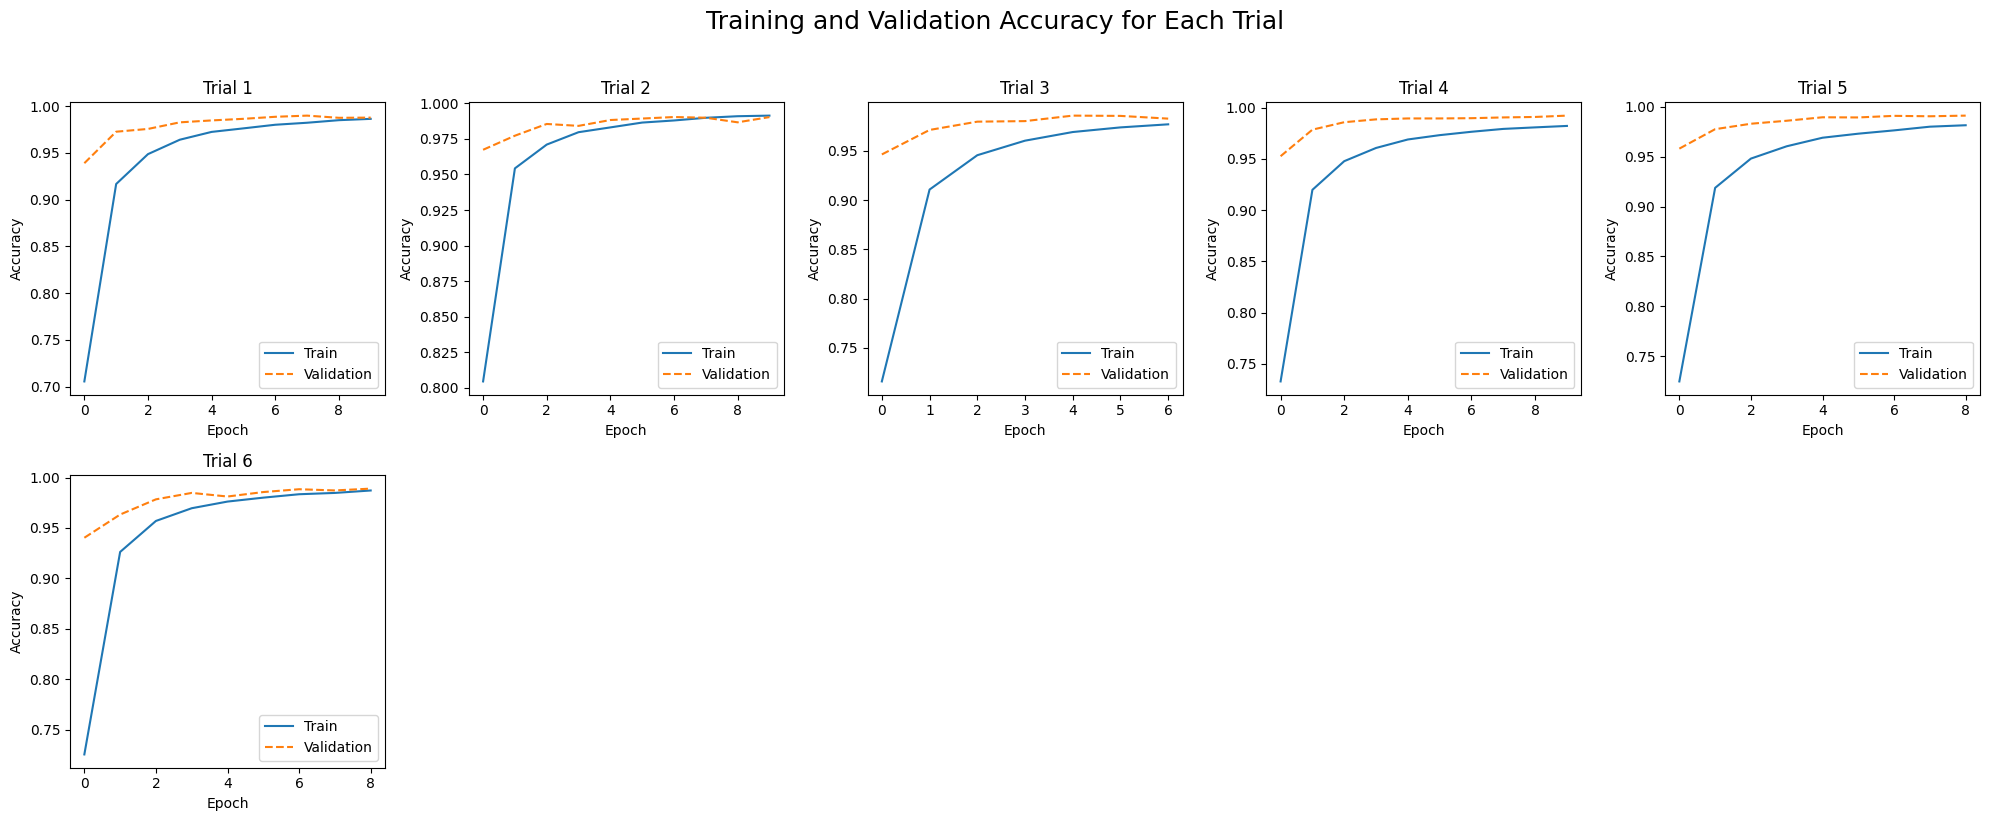

In [41]:
num_trials = min(len(trial_history), 10)
rows, cols = 2, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

for i in range(num_trials):
    trial = trial_history[i]
    ax = axes[i]
    ax.plot(trial['history']['accuracy'], label='Train')
    ax.plot(trial['history']['val_accuracy'], linestyle='--', label='Validation')
    ax.set_title(f"Trial {i+1}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='lower right')

# Hide unused subplots
for j in range(num_trials, len(axes)):
    axes[j].axis('off')

plt.suptitle("Training and Validation Accuracy for Each Trial", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### Best Model

- Hyper-parameters:
    - Number of filters 1 (`filters1`) = 32
    - Number of filters 2 (`filters2`) = 64
    - Number of convolutional blocks (`num_conv_blocks`) = 3
    - Dense layer units (`dense_units`) = 256
    - Dropout rate (`dropout`) = .5

- Architecture:
    - 3 convolutional layers
    - Filter depth (layer 1 = 32, layer 2 = 64, layer 3 = 128)
    - MaxPooling layers
    - ReLU activation
    - Dropout
    - Softmax output

In [ ]:
# Load the best model
best_trial = max(trial_history, key=lambda x: x['val_accuracy'])
print("\nBest Hyperparameters:")
for k, v in best_trial['hp'].items():
    print(f"{k}: {v}")

best_model = tf.keras.models.load_model(best_trial['model_path'])


Best Hyperparameters:
filters1: 32
filters2: 64
dense_units: 256
dropout: 0.5
num_conv_blocks: 3


In [42]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 23, 23, 128)     

### Error Analysis
Some misclassified examples

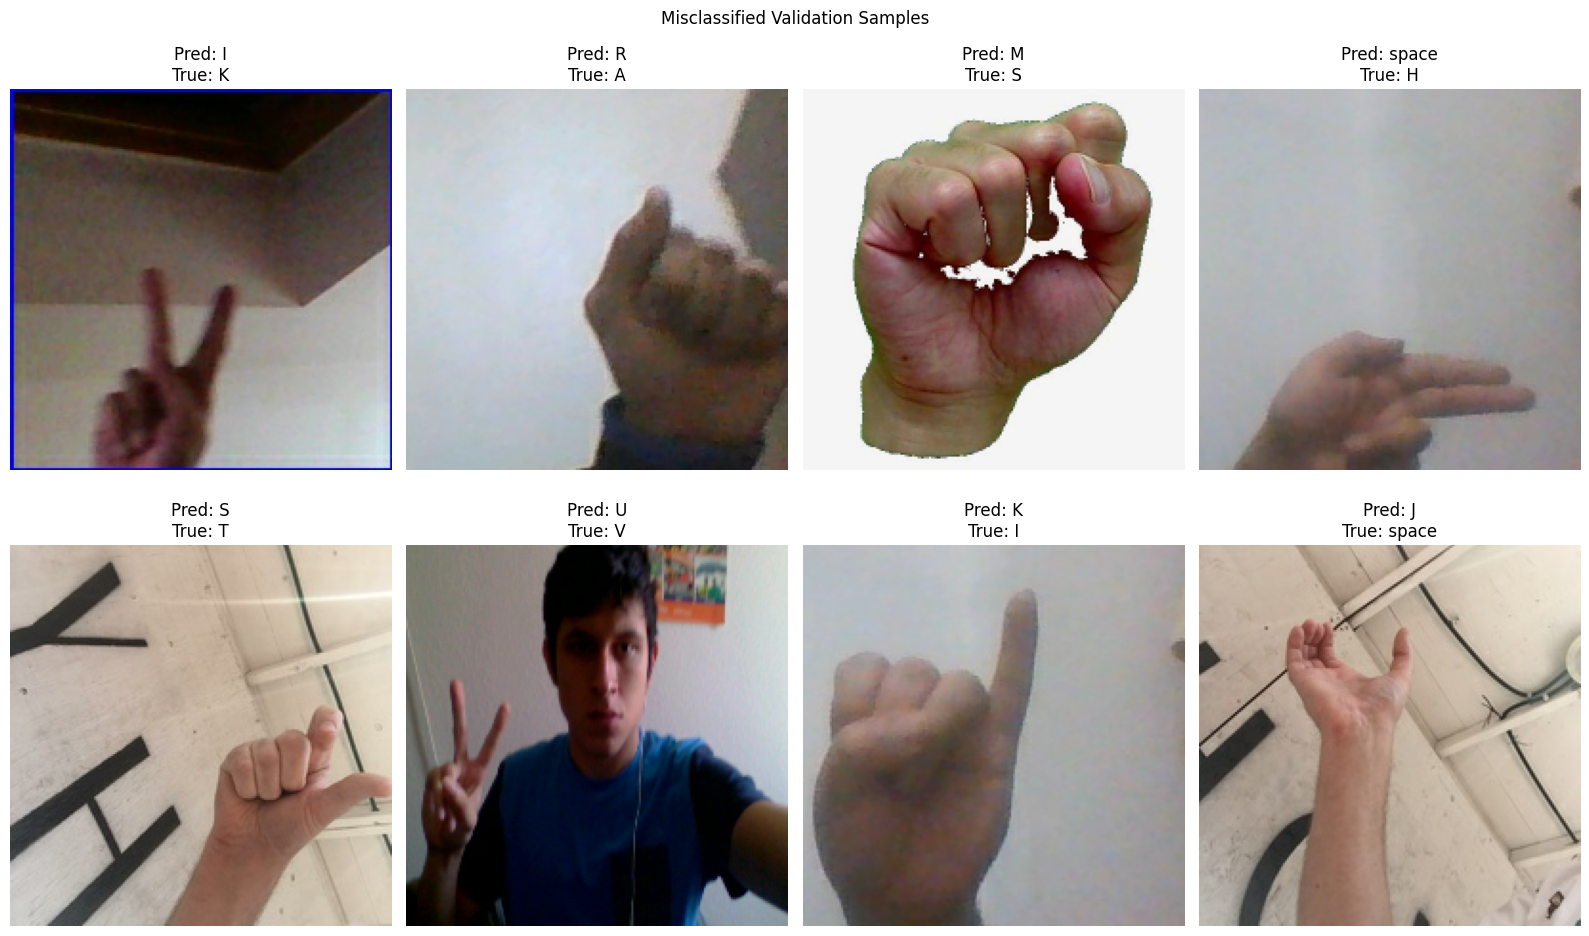

In [40]:
# Store misclassified examples
misclassified_images = []
misclassified_preds = []
misclassified_labels = []

for image, label in val_ds.unbatch().take(5000):
    img = tf.expand_dims(image, axis=0)
    pred = best_model.predict(img, verbose=0)
    pred_label = np.argmax(pred[0])
    true_label = label.numpy()

    if pred_label != true_label:
        misclassified_images.append(image.numpy())
        misclassified_preds.append(pred_label)
        misclassified_labels.append(true_label)

# Display a few misclassified examples
num_to_show = min(8, len(misclassified_images))
plt.figure(figsize=(16, 10))

for i in range(num_to_show):
    plt.subplot(2, 4, i + 1)
    plt.imshow(misclassified_images[i])
    plt.axis('off')
    plt.title(f"Pred: {class_names[misclassified_preds[i]]}\nTrue: {class_names[misclassified_labels[i]]}")

plt.suptitle("Misclassified Validation Samples")
plt.tight_layout()
plt.show()

---
# Final Results and Discussion

## Summary of Results

In [29]:
val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1352/1352 [==============================] - 23s 17ms/step - loss: 0.0360 - accuracy: 0.9922
Validation Loss: 0.0360
Validation Accuracy: 0.9922


In [34]:
# Get all labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

In [33]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.99      0.98      1654
           B       0.98      1.00      0.99      1678
           C       0.99      1.00      0.99      1661
           D       1.00      1.00      1.00      1566
           E       1.00      0.99      0.99      1541
           F       1.00      0.99      1.00      1607
           G       0.99      0.99      0.99      1583
           H       0.99      0.99      0.99      1528
           I       0.99      1.00      0.99      1593
           J       0.99      0.99      0.99      1541
           K       1.00      0.99      0.99      1558
           L       1.00      0.99      1.00      1654
           M       0.99      0.99      0.99      1585
           N       0.99      0.99      0.99      1641
           O       0.99      0.99      0.99      1598
           P       1.00      1.00      1.00      1505
           Q       0.99      0.99      0.99      1577
    

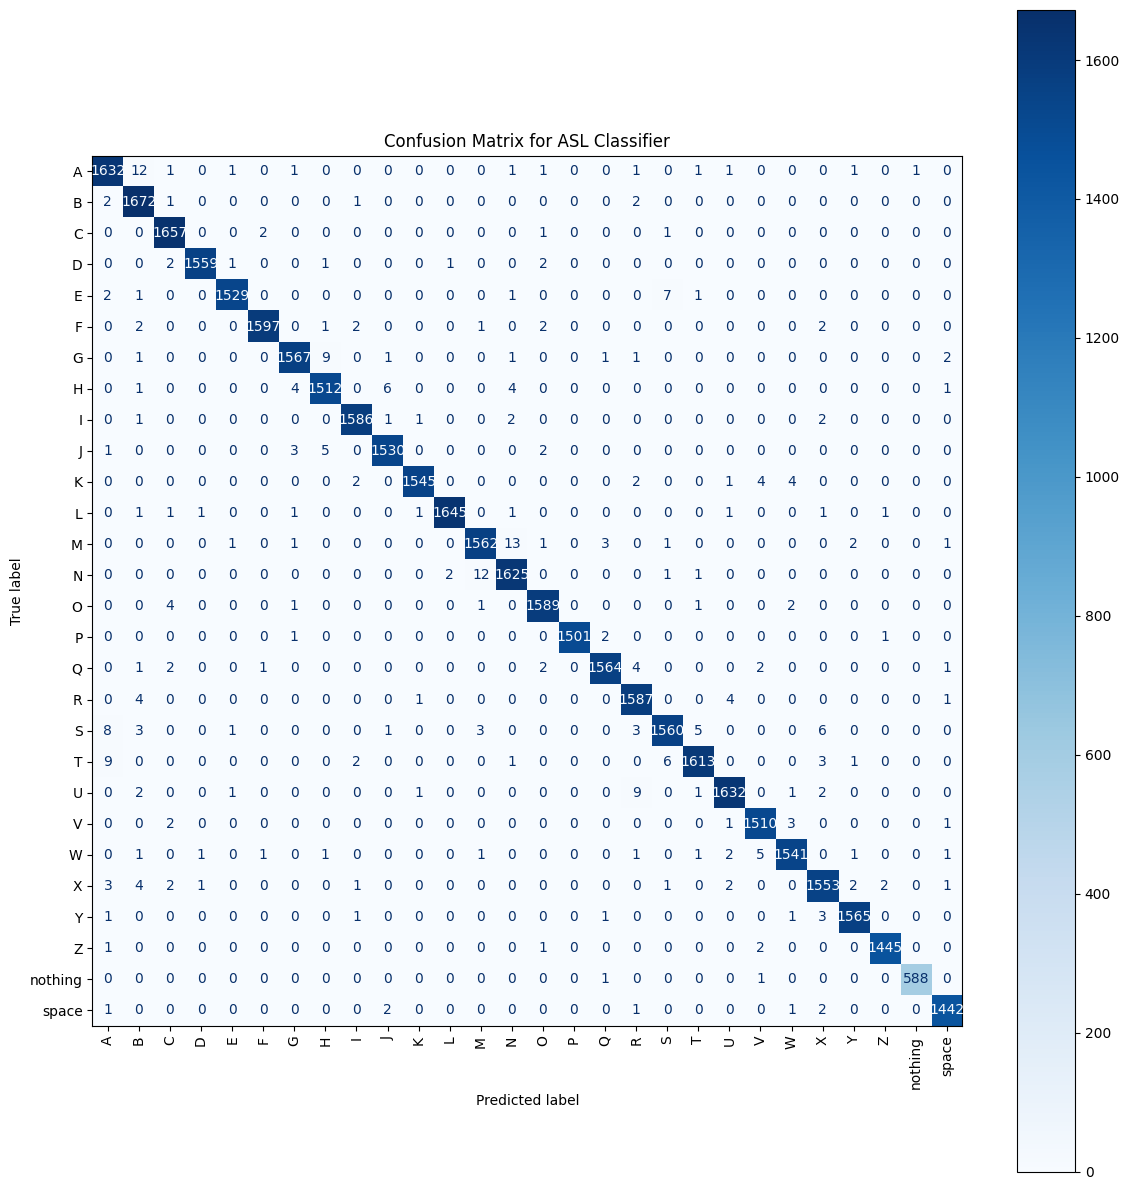

In [32]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix for ASL Classifier")
plt.tight_layout()
plt.show()

## Strengths and Limitations

### What the Model Did Well

- **High Accuracy** 
    - The final model achieved ~99% validation accuracy, demonstrating strong performance on a large and diverse ASL fingerspelling dataset.
- **Fast Convergence**  
    - With adam optimizer and dropout tuning, the model learned meaningful representations quickly and required relatively few epochs.
- **Generalization**  
    - The model maintained consistent performance across most ASL characters, showing it could generalize beyond the training data.
- **Error Localization**  
    - Misclassifications were limited and often involved visually similar gestures (e.g., M vs N), indicating the model learned semantically relevant features.

### Limitations and Challenges

- **Confusion Between Similar Signs**  
    - Some signs with similar hand shapes or orientations (e.g., O vs C, M vs N) were harder to distinguish, which is expected in a fine-grained classification task.
- **Validation as Test Proxy**  
    - Due to the lack of a separate test set, we used a validation split for performance reporting. While indicative, results may be slightly optimistic without true holdout testing.
- **Environmental Constraints**
    - The dataset was captured under controlled conditions. Real-world performance could degrade in varied lighting, backgrounds, or camera angles—further augmentation or transfer learning may be needed for robustness.


## Future Work
- **Data Augmentation**
    - Introduce augmentation techniques like slight rotation, zoom, and brightness shifts, to simulate real-world variability. This would help the model generalize better to new environments, hand positions, and lighting conditions.

- **Transfer Learning**
    - Explore fine-tuning pretrained CNNs such as MobileNetV2, ResNet50, or EfficientNet. These models have learned feature representations from large-scale image datasets (e.g., ImageNet) and could significantly boost performance and convergence speed.

- **Real-Time Inference**
    - Adapt the model to work with webcam input in real-time. This would allow for testing deployment viability in assistive applications like ASL-to-text translators.